# Predicción de Índices Bursátiles con Metódos de la estadística clasíca y series de tiempo
## Modelos ARMA, ARIMA Y SARIMA
### Introducción
En este noebook se realiza un anáisis de los métodos de series de tiempo de la estadística clásica con ayuda de la librería Statsmodels, inspirado en el artículo "Pronóstico de series de tiempo con Python" de Naren Castellón (https://github.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/tree/main). Esta variación está diseñada para la captura y preducción de diferentes índices bursátiles y las métricas de rendimiento.

En el artículo "PredStock: Una Comparación entre modelos paramétricos y no paramétricos para la predicción de índices bursátiles" (https://...) se compara este modelo con modelos de redes neuronales bayesianas. Este notebook se encontrará la recolección y preparación de datos, seguido con la ayuda de la librería se obtendrá el mejor modelo de los diferentes modelos, para realizar su análisis y posterior comparación.


## Librerías

In [148]:

# Tratamiento de datos
import pandas as pd
import numpy as np
import random

# Paquete para realizar Web Scraping de Yahoo Finance
import yfinance as yf

# Gráficos interactivos y isualización de datos
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Inactivación de mensages de advertencia
import warnings
warnings.filterwarnings('ignore')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Modelo Auto-Arima
from pmdarima import auto_arima

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

## Cargue de datos

Se encuentra un listado de cinco índices busrsátiles en tres continentes; Europa (Gran Bretaña: FTSE 100 y Alemania: Global X DAX Germany), Asia (Japón Nikkei 225) y América (EEUU: Dow Jones y EEUU: SYP 500).

In [149]:
FTSE=yf.download('^FTSE', start='2019-01-01', end='2023-05-28')
FTSE.reset_index(inplace=True)
FTSE=FTSE.drop(['Adj Close'], axis=1)
FTSE=pd.DataFrame(FTSE)

DAX=yf.download('DAX', start='2019-01-01', end='2023-05-28')
DAX.reset_index(inplace=True)
DAX=DAX.drop(['Adj Close'], axis=1)
DAX=pd.DataFrame(DAX)

N225=yf.download('^N225', start='2019-01-01', end='2023-05-28')
N225.reset_index(inplace=True)
N225=N225.drop(['Adj Close'], axis=1)
N225=pd.DataFrame(N225)

DJI=yf.download('^DJI', start='2019-01-01', end='2023-05-28')
DJI.reset_index(inplace=True)
DJI=DJI.drop(['Adj Close'], axis=1)
DJI=pd.DataFrame(DJI)

GSPC=yf.download('^GSPC', start='2019-01-01', end='2023-05-28')
GSPC.reset_index(inplace=True)
GSPC=GSPC.drop(['Adj Close'], axis=1)
GSPC=pd.DataFrame(GSPC)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Preparación de los datos
Una vez cargados los datos desde Yahoo Finance, se procederá a tomar la variable fecha como índice y los datos de apertura (Open) como la variable a predecir. Para evitar resagos y extraños en los datos originados por la pandemia del COVID-19 se tomará la serie desde 2022-06-01,para dicha variable se trabajará con el su logaritmo.

In [150]:
Seleccionadas=['Date', 'Open']

FTSE_2=FTSE[Seleccionadas]
FTSE_2=FTSE_2.loc[(FTSE_2['Date']>='2022-06-01')]
FTSE_2['Open']=np.log(FTSE_2['Open'])

DAX_2=DAX[Seleccionadas]
DAX_2=DAX_2.loc[(DAX_2['Date']>='2022-06-01')]
DAX_2['Open']=np.log(DAX_2['Open'])

N225_2=N225[Seleccionadas]
N225_2=N225_2.loc[(N225_2['Date']>='2022-06-01')]
N225_2['Open']=np.log(N225_2['Open'])

DJI_2=DJI[Seleccionadas]
DJI_2=DJI_2.loc[(DJI_2['Date']>='2022-06-01')]
DJI_2['Open']=np.log(DJI_2['Open'])

GSPC_2=GSPC[Seleccionadas]
GSPC_2=GSPC_2.loc[(GSPC_2['Date']>='2022-06-01')]
GSPC_2['Open']=np.log(GSPC_2['Open'])

#Gráfico de la serie
FTSE_D=go.Scatter(x=FTSE_2['Date'], y=FTSE_2['Open'], mode='lines', fill=None)
DAX_D=go.Scatter(x=DAX_2['Date'], y=DAX_2['Open'], mode='lines', fill=None)
N225_D=go.Scatter(x=N225_2['Date'], y=N225_2['Open'], mode='lines', fill=None)
DJI_D=go.Scatter(x=DJI_2['Date'], y=DJI_2['Open'], mode='lines', fill=None)
GSPC_D=go.Scatter(x=GSPC_2['Date'], y=GSPC_2['Open'], mode='lines', fill=None)

grafo_1=[FTSE_D, DAX_D, N225_D, DJI_D, GSPC_D]


fig = make_subplots(rows=3, cols=2, specs=[[{}, {}], [{}, {}], [{"colspan": 2}, None]],
                    subplot_titles=("Gran Bretaña FTSE 100", "Alemania Global X DAX Germany ETF", "Japón Nikkei 225", "EEUU Dow Jones", "EEUU S&P 500"))

fig.add_trace(FTSE_D, row=1, col=1)
fig.add_trace(DAX_D, row=1, col=2)
fig.add_trace(N225_D, row=2, col=1)
fig.add_trace(DJI_D, row=2, col=2)
fig.add_trace(GSPC_D, row=3, col=1)

fig.update_xaxes(title_text="Tiempo (Días Calendario)", row=1, col=1)
fig.update_yaxes(title_text="Log Precio Índice", row=1, col=1)
fig.update_xaxes(title_text="Tiempo (Días Calendario)", row=1, col=2)
fig.update_yaxes(title_text="Log Precio Índice", row=1, col=2)
fig.update_xaxes(title_text="Tiempo (Días Calendario)", row=2, col=1)
fig.update_yaxes(title_text="Log Precio Índice", row=2, col=1)
fig.update_xaxes(title_text="Tiempo (Días Calendario)", row=2, col=2)
fig.update_yaxes(title_text="Log Precio Índice", row=2, col=2)
fig.update_xaxes(title_text="Tiempo (Días Calendario)", row=3, col=1)
fig.update_yaxes(title_text="Log Precio Índice", row=3, col=1)

fig.update_layout(height=1050, width=1100, showlegend=False, paper_bgcolor='rgba(255,255,255,0.75)',
    plot_bgcolor='rgba(0,191,255,0.1)', font_color="blue")
fig.show()

### Arquitectura de los Modelos en Statsmodels

Statsmodels es una librería de Python que proporciona funciones para la estimación de muchos modelos estadísticos, entre ellos las series temporales. Hay disponible una extensa lista de estadísticas de resultados para cada estimador.

El modelo SARIMA (Seasional Arima), es una extensión de ARIMA que admite explícitamente datos de series temporales univariadas con un componente estacional. Agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), diferenciación (I) y media móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para el período de la estacionalidad.

La función auto-ARIMA permite identificar los parámetros más óptimos para un modelo autoregresivo (AR) integrado (I) con media móvil (MA) ARIMA, el modelo indica por un solo modelo ARIMA ajustado identificado por ser el de menor AIC. En la documentación de la librería indica que: "Auto-ARIMA funciona mediante la realización de pruebas de diferenciación (es decir, Kwiatkowski–Phillips–Schmidt– Shin , Dickey-Fuller aumentada o Phillips–Perron) para determinar el orden de diferenciación y luego ajustar los modelos ddentro de los rangos definidos".

Hay cuatro elementos estacionales que no forman parte de ARIMA que deben configurarse; ellos son:

-P: orden autorregresivo estacional.

-D: Orden de diferencia estacional.

-P: Orden promedio móvil estacional.

-m: El número de pasos de tiempo para un solo período estacional.

### La prueba de Dickey-Fuller aumentada
Naren Castellón indica que: "una prueba de Dickey-Fuller aumentada (ADF) es un tipo de prueba estadística que determina si una raíz unitaria está presente en los datos de series de tiempo. Las raíces unitarias pueden causar resultados impredecibles en el análisis de series de tiempo. Se forma una hipótesis nula en la prueba de raíz unitaria para determinar qué tan fuertemente los datos de series temporales se ven afectados por una tendencia. Al aceptar la hipótesis nula, aceptamos la evidencia de que los datos de la serie temporal no son estacionarios. Al rechazar la hipótesis nula o aceptar la hipótesis alternativa, aceptamos la evidencia de que los datos de la serie de tiempo son generados por un proceso estacionario. Este proceso también se conoce como tendencia estacionaria. Los valores de la estadística de prueba ADF son negativos. Los valores más bajos de ADF indican un rechazo más fuerte de la hipótesis nula".

In [151]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

### Función de Evalaución de Resultados

In [236]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

## Gran Bretaña FTSE 100

In [152]:
## Infromación del conjunto de datos
FTSE_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 862 to 1108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    247 non-null    datetime64[ns]
 1   Open    247 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [153]:
## Establecer la columna Date como index
FTSE_2_1 = FTSE_2.set_index("Date")

In [154]:
FTSE_2_2=FTSE_2_1.copy()
# Tomar la priemra diferencia
FTSE_2_2['Open_diff'] = FTSE_2_1['Open'].diff()

# Remover el primer datos de la lista
FTSE_2_2.dropna(inplace=True)

# Encabezado de la base de datos
FTSE_2_2.head()

,Open,Open_diff
Date,,
2022-06-06,8.927049,-0.009868
2022-06-07,8.936982,0.009933
2022-06-08,8.935759,-0.001223
2022-06-09,8.934982,-0.000777
2022-06-10,8.919480,-0.015502


In [155]:
## Prueba de Dickey_Fuller
Prueba_Dickey_Fuller(FTSE_2_2["Open_diff"],"Open_diff")

Resultados de la prueba de Dickey-Fuller para columna: Open_diff
Test Statistic                       -1.585217e+01
p-value                               9.421167e-29
No Lags Used                          0.000000e+00
Número de observaciones utilizadas    2.450000e+02
Critical Value (1%)                  -3.457326e+00
Critical Value (5%)                  -2.873410e+00
Critical Value (10%)                 -2.573096e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


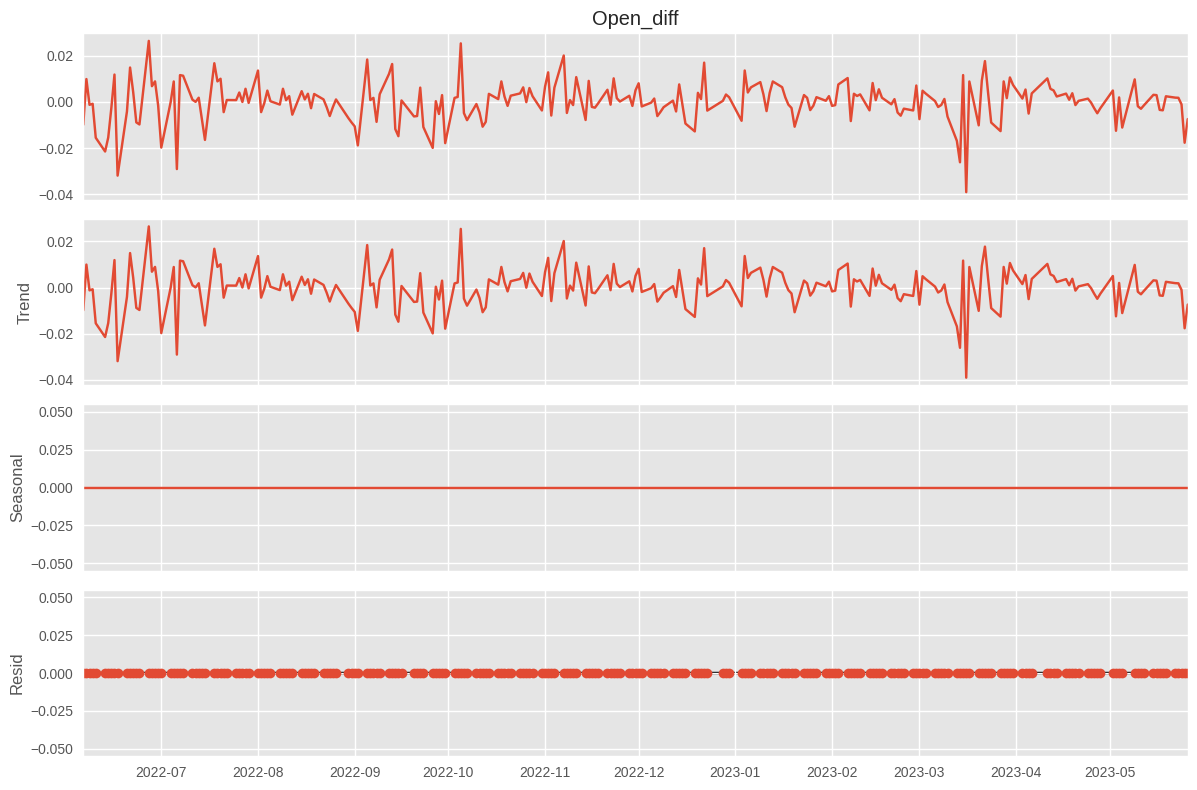

In [156]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(FTSE_2_2["Open_diff"], model = "add", period=1)
a.plot();

### División de entrenamiento y prueba

In [157]:
train_data_FTSE_2 = FTSE_2[:len(FTSE_2)-65]
train_data_FTSE_2=train_data_FTSE_2.drop(train_data_FTSE_2.columns[0], axis=1)
test_data_FTSE_2 = FTSE_2_2[len(FTSE_2)-65:]
test_data_FTSE_2=test_data_FTSE_2.drop(test_data_FTSE_2.columns[0], axis=1)
test_FTSE_2=test_data_FTSE_2.copy()

In [158]:
train_data_FTSE_2.shape, test_data_FTSE_2.shape

((182, 1), (64, 1))

#### Modelo Auto-Arima
Ejecutemos la función auto_arima() para obtener los mejores parametros de p,d,q,P,D,Q

In [161]:
modelo_auto_FTSE=auto_arima(train_data_FTSE_2,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto_FTSE)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1008.347, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1055.703, Time=0.90 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1084.472, Time=2.89 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-1006.867, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-1079.395, Time=2.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=9.59 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-1055.686, Time=0.59 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-1079.109, Time=2.92 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=2.64 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-1084.402, Time=3.89 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]    

In [162]:
print(modelo_auto_FTSE.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  182
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 545.236
Date:                            Fri, 18 Aug 2023   AIC                          -1084.472
Time:                                    18:13:30   BIC                          -1075.082
Sample:                                         0   HQIC                         -1080.661
                                            - 182                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0283      0.062      0.455      0.649      -0.093       0.150
ma.S.L12      -0.8777      0.127   

### Implementación del Modelo

In [163]:
arima_model_FTSE = SARIMAX(train_data_FTSE_2["Open"], order = (0,1,1), seasonal_order = (2,1,2,12))
arima_result_FTSE = arima_model_FTSE.fit()
arima_result_FTSE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Open   No. Observations:                  182
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 543.366
Date:                                 Fri, 18 Aug 2023   AIC                          -1074.733
Time:                                         18:13:36   BIC                          -1055.953
Sample:                                              0   HQIC                         -1067.112
                                                 - 182                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0476      0.065      0.731      0.465      -0.080       0.175
ar.S.L12      -0.4089      1.871     -0.219      0.827      -4.075       3.257
ar.S.L24      -0.0676      0.144     -0.470      0.638      -0.350       0.214
ma.S.L12      -0.4203      1.849     -0.227      0.820      -4.043       3.203
ma.S.L24      -0.2512      1.472     -0.171      0.865      -3.137       2.635
sigma2      8.786e-05   9.63e-06      9.122      0.000     6.9e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 6.16
Prob(Q):                              0.45   Prob(JB):                         0.05
Heteroskedasticity (H):               0.30   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

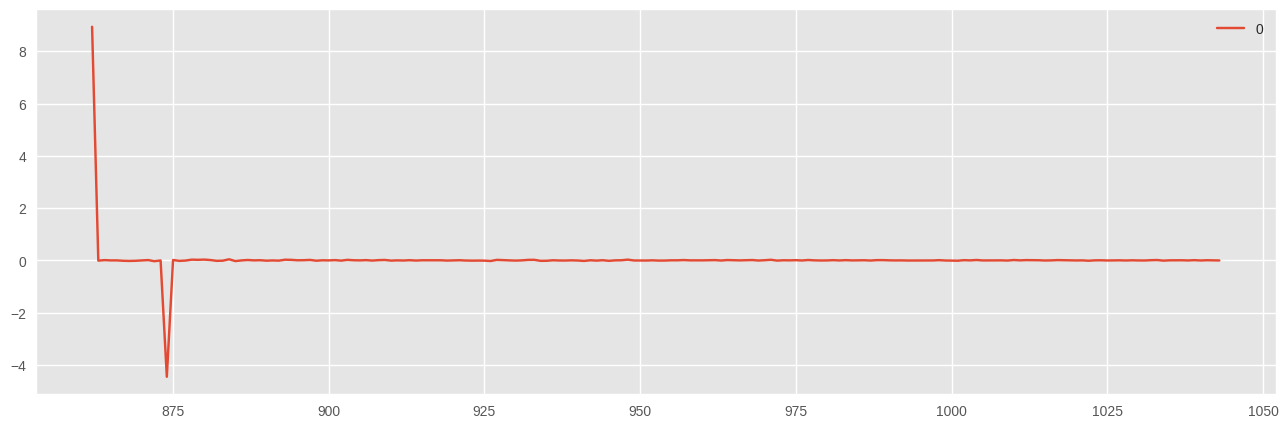

In [164]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result_FTSE.resid)
residuals.plot(figsize = (16,5));
plt.show();

#### Cómo interpretar las gráficas de residuos en el modelo ARIMA
Repasemos las gráficas de residuos usando stepwise_fit.

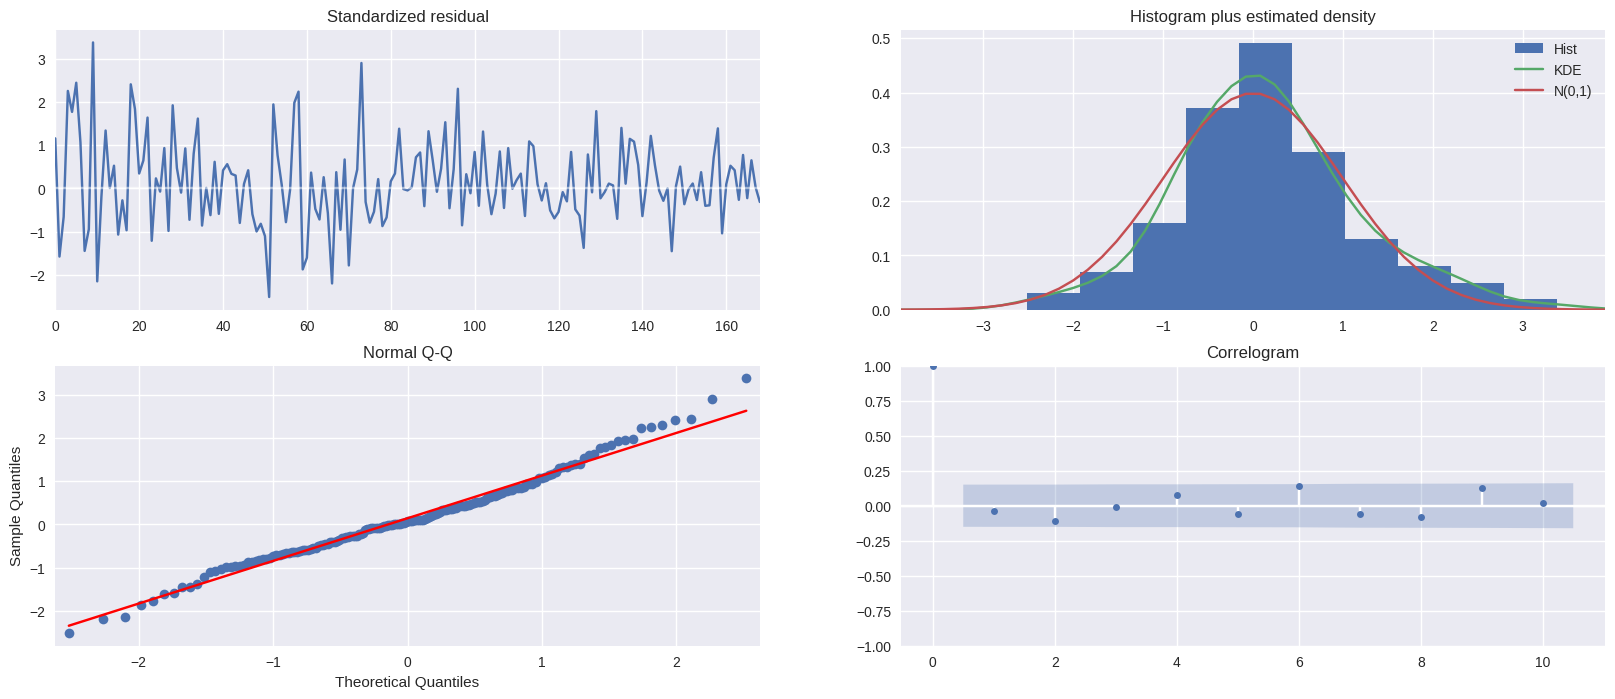

In [165]:
plt.style.use('seaborn')
modelo_auto_FTSE.plot_diagnostics(figsize=(20,8))
plt.show()

### Gráfico de resultados

In [217]:
arima_pred_FTSE = arima_result_FTSE.predict(start = len(train_data_FTSE_2), end = len(FTSE_2)-1, typ="levels").rename("ARIMA Predictions")

std_pred_FTSE=np.std(arima_pred_FTSE)
sig_3_mas_FTSE=arima_pred_FTSE+3*std_pred_FTSE
sig_3_men_FTSE=arima_pred_FTSE-3*std_pred_FTSE
sig_2_mas_FTSE=arima_pred_FTSE+2*std_pred_FTSE
sig_2_men_FTSE=arima_pred_FTSE-2*std_pred_FTSE

Tiempo = FTSE_2[len(FTSE_2)-65:]
tiempo_FTSE=Tiempo['Date']
datos_FTSE=Tiempo['Open']

upper_trace_FTSE = go.Scatter(x=tiempo_FTSE,
                    y=sig_3_mas_FTSE,
                    mode='lines',
                    fill=None,
                    name='Lím. Sup. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

upper_trace_2_FTSE = go.Scatter(x=tiempo_FTSE,
                    y=sig_2_mas_FTSE,
                    mode='lines',
                    fill=None,
                    name='Lím. Superior 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

lower_trace_FTSE = go.Scatter(x=tiempo_FTSE,
                    y=sig_3_men_FTSE,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

lower_trace_2_FTSE = go.Scatter(x=tiempo_FTSE,
                    y=sig_2_men_FTSE,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

real_trace_FTSE = go.Scatter(x=tiempo_FTSE,
                    y=datos_FTSE,
                    mode='lines',
                    fill=None,
                    name='Valores reales'
                    )

mean_trace_FTSE=go.Scatter(x=tiempo_FTSE,
                    y=arima_pred_FTSE,
                    mode='lines',
                    fill=None,
                    name='Valores modelados'
                    )

data_FTSE_3 = [upper_trace_2_FTSE, lower_trace_2_FTSE, upper_trace_FTSE, lower_trace_FTSE, real_trace_FTSE, mean_trace_FTSE]

fig_FTSE_est = go.Figure(data=data_FTSE_3)
fig_FTSE_est.update_layout(title='Cuantificación de incertidumbre Gran Bretaña FTSE 100',
            xaxis_title='Tiempo',
            yaxis_title='log_Open (USD)')

fig_FTSE_est.update_layout(height=600, width=1000, paper_bgcolor='rgba(255,255,255,0.75)',
    plot_bgcolor='rgba(0,191,255,0.1)', font_color="blue")

fig_FTSE_est.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.01), legend_font_size=10)

fig_FTSE_est.show()

### Evaluación de la Incertidumbre

# Using 99% confidence bounds
conteo_1_FTSE=0
conteo_2_FTSE=0
for i in range(len(datos_FTSE)):
  if((datos_FTSE.iloc[i]>=sig_3_men_FTSE.iloc[i]) & (datos_FTSE.iloc[i]<=sig_3_mas_FTSE.iloc[i])):
    conteo_1_FTSE=conteo_1_FTSE+1

for i in range(len(datos_FTSE)):
  if((datos_FTSE.iloc[i]>=sig_2_men_FTSE.iloc[i]) & (datos_FTSE.iloc[i]<=sig_2_mas_FTSE.iloc[i])):
    conteo_2_FTSE=conteo_2_FTSE+1

rango_1_FTSE=conteo_1_FTSE/65
rango_2_FTSE=conteo_2_FTSE/65

print("Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%):", rango_1_FTSE)
print("Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%):", rango_2_FTSE)

Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%): 0.4
Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%): 0.2153846153846154


### Evaluación de los resultados

In [239]:
evaluacion_metrica(datos_FTSE, arima_pred_FTSE)

Evaluation metric results:-
MSE is : 0.005861629600826781
MAE is : 0.06960373673940538
RMSE is : 0.07656128003649613
MAPE is : 0.7779127694601162
R2 is : -11.067470706639483



## Alemania Global X DAX Germany ETF

In [218]:
## Infromación del conjunto de datos
DAX_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 860 to 1108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    249 non-null    datetime64[ns]
 1   Open    249 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [221]:
## Establecer la columna Date como index
DAX_2_1 = DAX_2.set_index("Date")

In [222]:
DAX_2_2=DAX_2_1.copy()
# Tomar la priemra diferencia
DAX_2_2['Open_diff'] = DAX_2_1['Open'].diff()

# Remover el primer datos de la lista
DAX_2_2.dropna(inplace=True)

# Encabezado de la base de datos
DAX_2_2.head()

,Open,Open_diff
Date,,
2022-06-02,3.315640,-0.002901
2022-06-03,3.320710,0.005071
2022-06-06,3.330059,0.009349
2022-06-07,3.314186,-0.015873
2022-06-08,3.317816,0.003630


In [223]:
## Prueba de Dickey_Fuller
Prueba_Dickey_Fuller(DAX_2_2["Open_diff"],"Open_diff")

Resultados de la prueba de Dickey-Fuller para columna: Open_diff
Test Statistic                       -1.528523e+01
p-value                               4.520543e-28
No Lags Used                          0.000000e+00
Número de observaciones utilizadas    2.470000e+02
Critical Value (1%)                  -3.457105e+00
Critical Value (5%)                  -2.873314e+00
Critical Value (10%)                 -2.573044e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


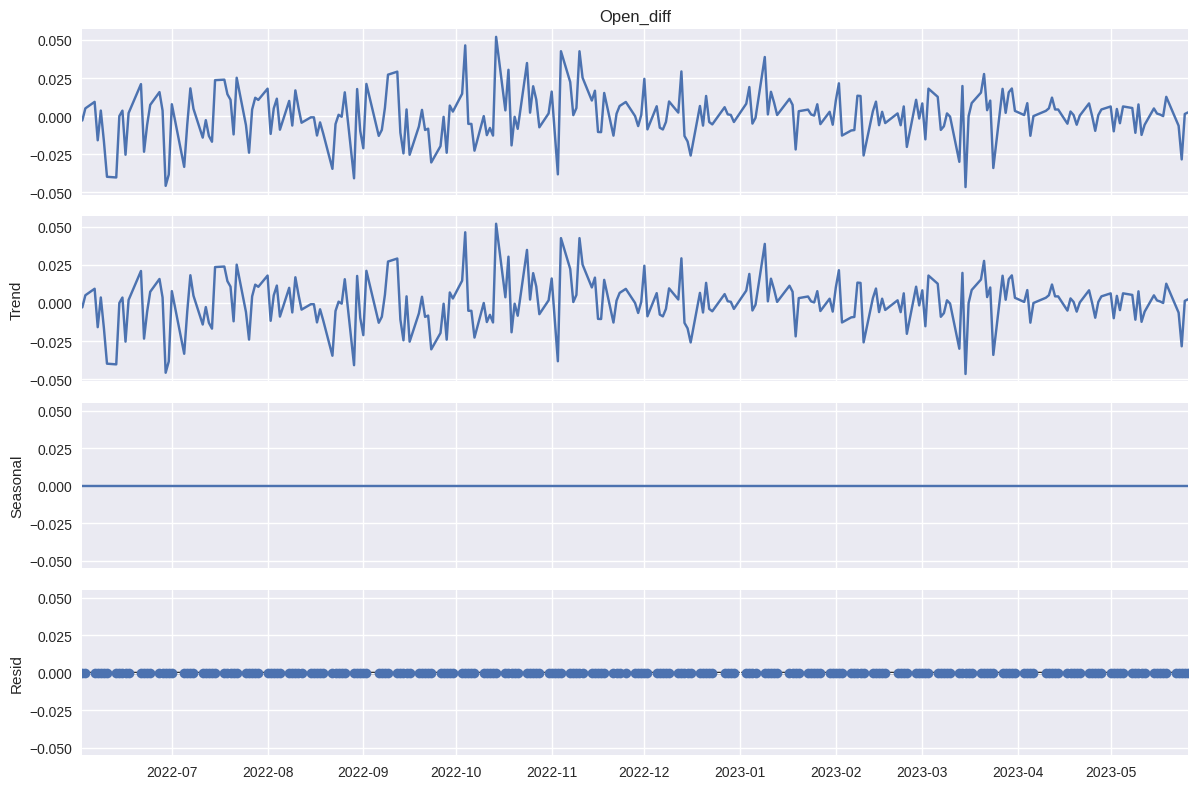

In [224]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(DAX_2_2["Open_diff"], model = "add", period=1)
a.plot();

In [225]:
train_data_DAX_2 = DAX_2[:len(DAX_2)-65]
train_data_DAX_2=train_data_DAX_2.drop(train_data_DAX_2.columns[0], axis=1)
test_data_DAX_2 = DAX_2_2[len(DAX_2)-65:]
test_data_DAX_2=test_data_DAX_2.drop(test_data_DAX_2.columns[0], axis=1)
test_DAX_2=test_data_DAX_2.copy()

In [226]:
train_data_DAX_2.shape, test_data_DAX_2.shape

((184, 1), (64, 1))

#### Modelo Auto-Arima
Ejecutemos la función auto_arima() para obtener los mejores parametros de p,d,q,P,D,Q

In [228]:
modelo_auto_DAX=auto_arima(train_data_DAX_2,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto_DAX)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-777.366, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-820.815, Time=1.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-775.393, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-842.096, Time=3.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-864.740, Time=10.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-864.611, Time=2.15 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=10.35 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=4.96 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.05 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-862.256, Time=5.96 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-864.800, Time=4.48 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-84

In [229]:
print(modelo_auto_DAX.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 439.200
Date:                            Fri, 18 Aug 2023   AIC                           -866.401
Time:                                    19:09:54   BIC                           -847.551
Sample:                                         0   HQIC                          -858.752
                                            - 184                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      1.553      0.121      -0.000       0.002
ma.L1          0.0293      0.070   

In [230]:
arima_model_DAX = SARIMAX(train_data_DAX_2["Open"], order = (0,1,1), seasonal_order = (2,1,2,12))
arima_result_DAX = arima_model_DAX.fit()
arima_result_DAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Open   No. Observations:                  184
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 437.642
Date:                                 Fri, 18 Aug 2023   AIC                           -863.283
Time:                                         19:10:31   BIC                           -844.433
Sample:                                              0   HQIC                          -855.635
                                                 - 184                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0638      0.070      0.913      0.361      -0.073       0.201
ar.S.L12      -0.7717      0.533     -1.447      0.148      -1.817       0.273
ar.S.L24      -0.1083      0.108     -1.000      0.317      -0.320       0.104
ma.S.L12      -0.2004      0.514     -0.390      0.697      -1.207       0.807
ma.S.L24      -0.6499      0.575     -1.129      0.259      -1.778       0.478
sigma2         0.0003   4.07e-05      7.523      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 9.23
Prob(Q):                              0.69   Prob(JB):                         0.01
Heteroskedasticity (H):               0.55   Skew:                             0.48
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

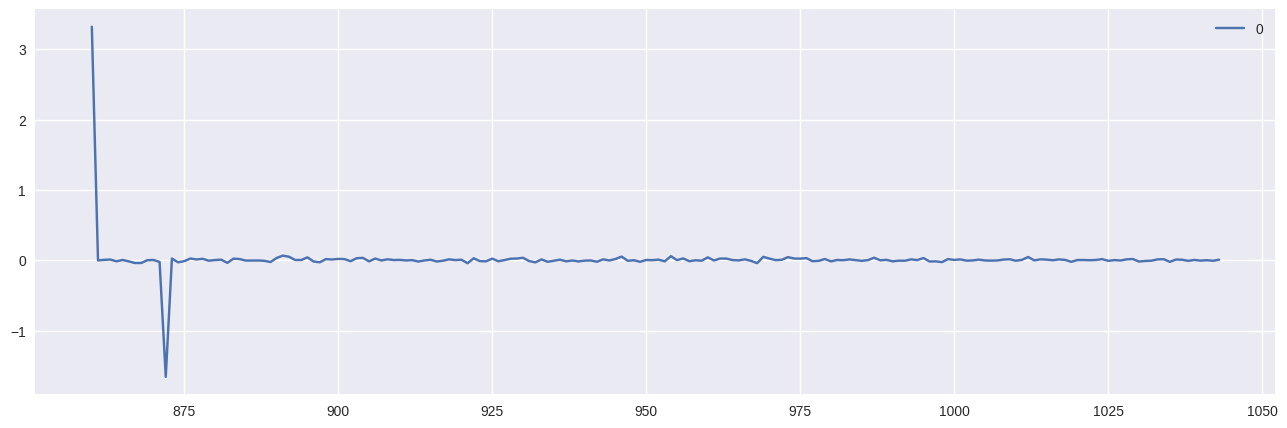

In [231]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result_DAX.resid)
residuals.plot(figsize = (16,5));
plt.show();

#### Cómo interpretar las gráficas de residuos en el modelo ARIMA
Repasemos las gráficas de residuos usando stepwise_fit.

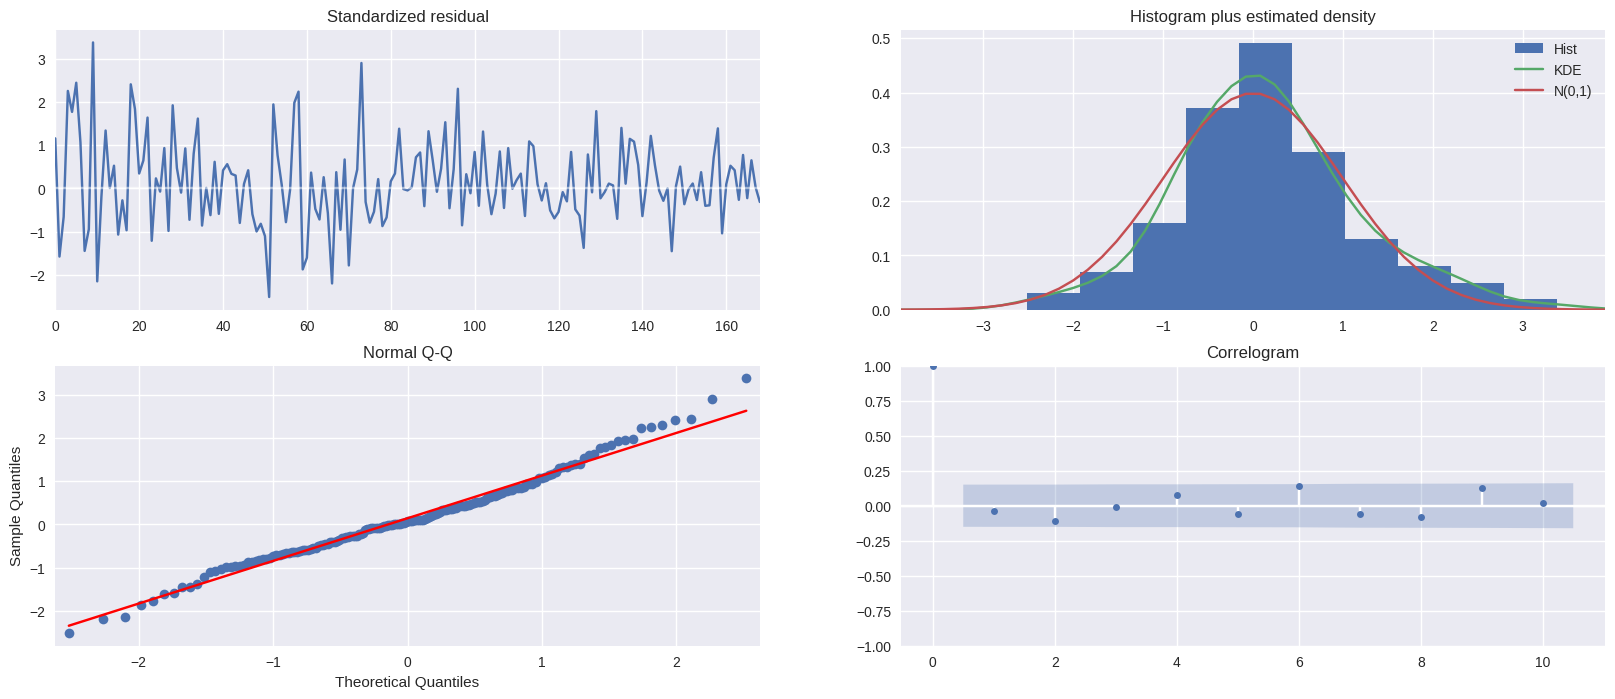

In [232]:
plt.style.use('seaborn')
modelo_auto_FTSE.plot_diagnostics(figsize=(20,8))
plt.show()

### Gráfico de resultados

In [255]:
arima_pred_DAX = arima_result_DAX.predict(start = len(train_data_DAX_2), end = len(DAX_2)-1, typ="levels").rename("ARIMA Predictions")

std_pred_DAX=np.std(arima_pred_DAX)
sig_3_mas_DAX=arima_pred_DAX+3*std_pred_DAX
sig_3_men_DAX=arima_pred_DAX-3*std_pred_DAX
sig_2_mas_DAX=arima_pred_DAX+2*std_pred_DAX
sig_2_men_DAX=arima_pred_DAX-2*std_pred_DAX

Tiempo = DAX_2[len(DAX_2)-65:]
tiempo_DAX=Tiempo['Date']
datos_DAX=Tiempo['Open']

upper_trace_DAX = go.Scatter(x=tiempo_DAX,
                    y=sig_3_mas_DAX,
                    mode='lines',
                    fill=None,
                    name='Lím. Sup. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

upper_trace_2_DAX = go.Scatter(x=tiempo_DAX,
                    y=sig_2_mas_DAX,
                    mode='lines',
                    fill=None,
                    name='Lím. Superior 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

lower_trace_DAX = go.Scatter(x=tiempo_DAX,
                    y=sig_3_men_DAX,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

lower_trace_2_DAX = go.Scatter(x=tiempo_DAX,
                    y=sig_2_men_DAX,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

real_trace_DAX = go.Scatter(x=tiempo_DAX,
                    y=datos_DAX,
                    mode='lines',
                    fill=None,
                    name='Valores reales'
                    )

mean_trace_DAX=go.Scatter(x=tiempo_DAX,
                    y=arima_pred_DAX,
                    mode='lines',
                    fill=None,
                    name='Valores modelados'
                    )

data_DAX_3 = [upper_trace_2_DAX, lower_trace_2_DAX, upper_trace_DAX, lower_trace_DAX, real_trace_DAX, mean_trace_DAX]

fig_DAX_est = go.Figure(data=data_DAX_3)
fig_DAX_est.update_layout(title='Cuantificación de incertidumbre Global X DAX Germany ETF',
            xaxis_title='Tiempo',
            yaxis_title='log_Open (USD)')

fig_DAX_est.update_layout(height=600, width=1000, paper_bgcolor='rgba(255,255,255,0.75)',
    plot_bgcolor='rgba(0,191,255,0.1)', font_color="blue")

fig_DAX_est.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.01), legend_font_size=10)

fig_DAX_est.show()

### Evaluación de la Incertidumbre

# Using 99% confidence bounds
conteo_1_DAX=0
conteo_2_DAX=0
for i in range(len(datos_DAX)):
  if((datos_DAX.iloc[i]>=sig_3_men_DAX.iloc[i]) & (datos_DAX.iloc[i]<=sig_3_mas_DAX.iloc[i])):
    conteo_1_DAX=conteo_1_DAX+1

for i in range(len(datos_DAX)):
  if((datos_DAX.iloc[i]>=sig_2_men_DAX.iloc[i]) & (datos_DAX.iloc[i]<=sig_2_mas_DAX.iloc[i])):
    conteo_2_DAX=conteo_2_DAX+1

rango_1_DAX=conteo_1_DAX/65
rango_2_DAX=conteo_2_DAX/65

print("Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%):", rango_1_DAX)
print("Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%):", rango_2_DAX)

Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%): 0.9076923076923077
Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%): 0.8461538461538461


### Evaluación de los resultados

In [238]:
evaluacion_metrica(datos_DAX, arima_pred_DAX)

Evaluation metric results:-
MSE is : 0.0005852453522793183
MAE is : 0.018752663521997576
RMSE is : 0.02419184474733827
MAPE is : 0.5586455933783887
R2 is : 0.4395810154418148



## Japón Nikkei 225

In [240]:
## Infromación del conjunto de datos
N225_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 826 to 1068
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    243 non-null    datetime64[ns]
 1   Open    243 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.7 KB


In [241]:
## Establecer la columna Date como index
N225_2_1 = N225_2.set_index("Date")

In [242]:
N225_2_2=N225_2_1.copy()
# Tomar la priemra diferencia
N225_2_2['Open_diff'] = N225_2_1['Open'].diff()

# Remover el primer datos de la lista
N225_2_2.dropna(inplace=True)

# Encabezado de la base de datos
N225_2_2.head()

,Open,Open_diff
Date,,
2022-06-02,10.216125,0.001643
2022-06-03,10.227765,0.011640
2022-06-06,10.223745,-0.004020
2022-06-07,10.239416,0.015672
2022-06-08,10.243534,0.004118


In [243]:
## Prueba de Dickey_Fuller
Prueba_Dickey_Fuller(N225_2_2["Open_diff"],"Open_diff")

Resultados de la prueba de Dickey-Fuller para columna: Open_diff
Test Statistic                       -1.389118e+01
p-value                               5.963868e-26
No Lags Used                          0.000000e+00
Número de observaciones utilizadas    2.410000e+02
Critical Value (1%)                  -3.457779e+00
Critical Value (5%)                  -2.873609e+00
Critical Value (10%)                 -2.573202e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


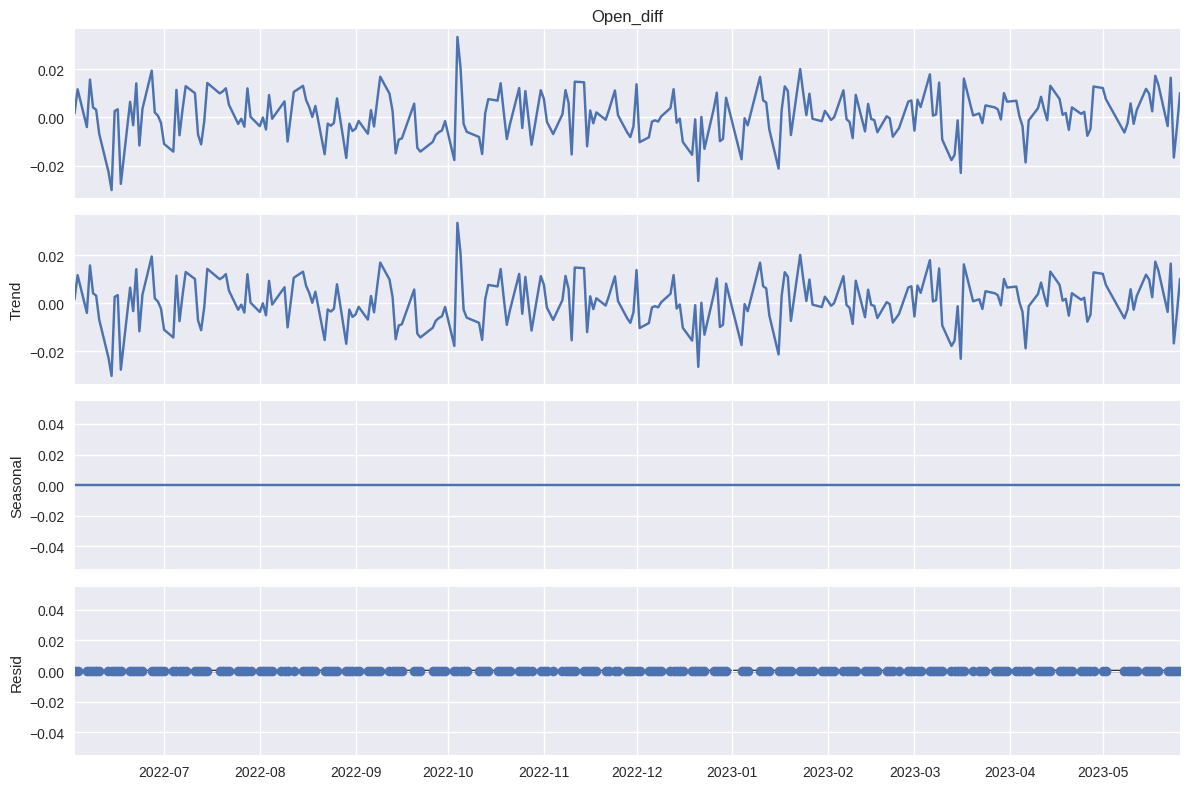

In [244]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(N225_2_2["Open_diff"], model = "add", period=1)
a.plot();

In [245]:
train_data_N225_2 = N225_2[:len(N225_2)-65]
train_data_N225_2=train_data_N225_2.drop(train_data_N225_2.columns[0], axis=1)
test_data_N225_2 = N225_2_2[len(N225_2)-65:]
test_data_N225_2=test_data_N225_2.drop(test_data_N225_2.columns[0], axis=1)
test_N225_2=test_data_N225_2.copy()

In [246]:
train_data_N225_2.shape, test_data_N225_2.shape

((178, 1), (64, 1))

#### Modelo Auto-Arima
Ejecutemos la función auto_arima() para obtener los mejores parametros de p,d,q,P,D,Q

In [247]:
# Modelo Auto-Arima
from pmdarima import auto_arima

In [248]:
modelo_auto_N225=auto_arima(train_data_N225_2,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto_N225)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-931.847, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-966.409, Time=1.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-931.070, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-984.295, Time=3.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-1011.699, Time=11.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-1013.656, Time=4.81 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=6.81 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.89 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-1011.288, Time=12.40 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.45 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.04 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-1011.136, Time=7.97 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=

In [249]:
print(modelo_auto_N225.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  178
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 510.828
Date:                              Fri, 18 Aug 2023   AIC                          -1013.656
Time:                                      19:27:46   BIC                          -1001.233
Sample:                                           0   HQIC                         -1008.613
                                              - 178                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0794      0.070      1.133      0.257      -0.058       0.217
ar.S.L12      -0.09

In [250]:
arima_model_N225 = SARIMAX(train_data_N225_2["Open"], order = (0,1,1), seasonal_order = (2,1,2,12))
arima_result_N225 = arima_model_N225.fit()
arima_result_N225.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Open   No. Observations:                  178
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 511.966
Date:                                 Fri, 18 Aug 2023   AIC                          -1011.932
Time:                                         19:28:16   BIC                           -993.296
Sample:                                              0   HQIC                         -1004.367
                                                 - 178                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1131      0.075      1.509      0.131      -0.034       0.260
ar.S.L12      -0.7665      0.818     -0.937      0.349      -2.371       0.838
ar.S.L24      -0.1014      0.110     -0.920      0.357      -0.317       0.115
ma.S.L12      -0.2527      0.814     -0.311      0.756      -1.847       1.342
ma.S.L24      -0.6518      0.846     -0.771      0.441      -2.309       1.006
sigma2         0.0001   2.32e-05      4.341      0.000    5.52e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.01
Prob(Q):                              0.88   Prob(JB):                         0.05
Heteroskedasticity (H):               0.79   Skew:                             0.34
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

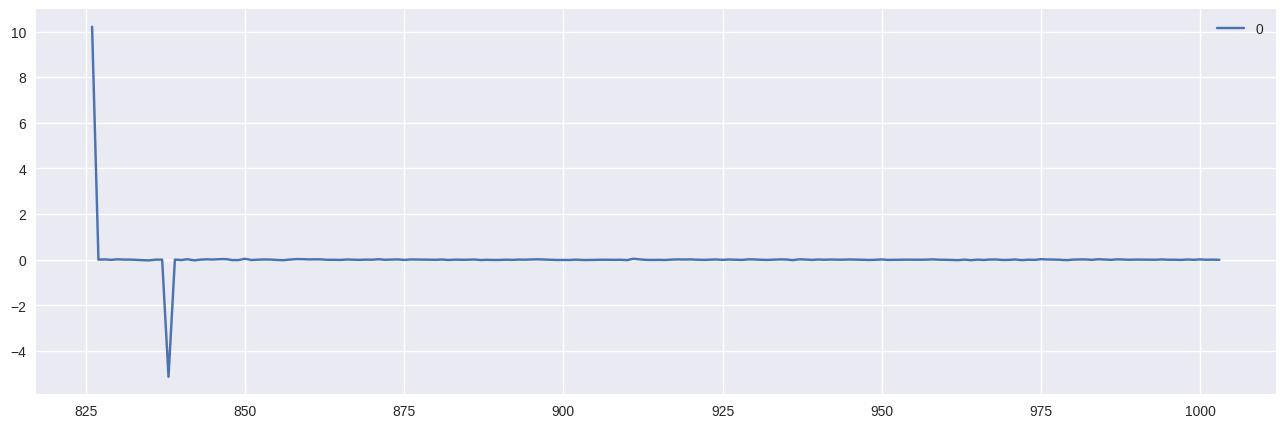

In [251]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result_N225.resid)
residuals.plot(figsize = (16,5));
plt.show();

#### Cómo interpretar las gráficas de residuos en el modelo ARIMA
Repasemos las gráficas de residuos usando stepwise_fit.

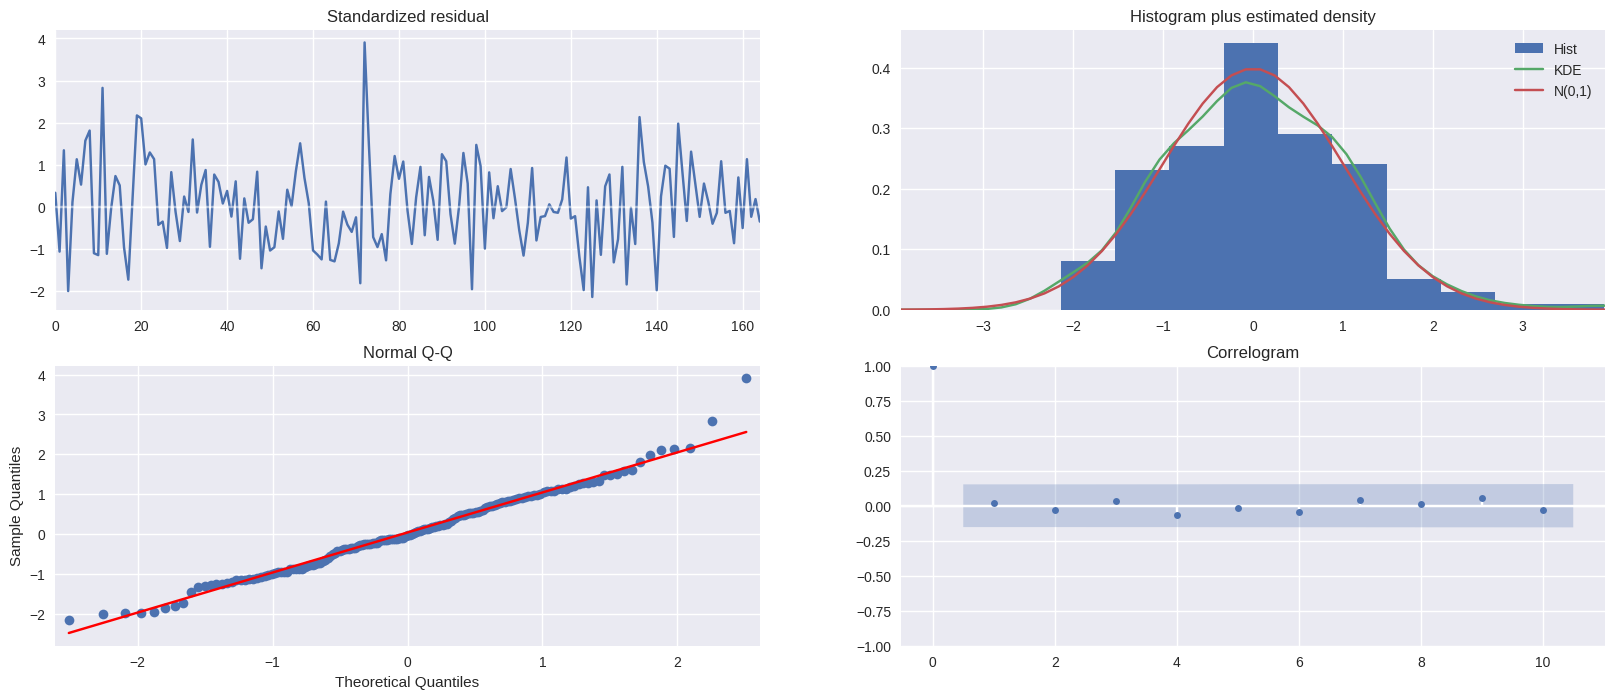

In [252]:
plt.style.use('seaborn')
modelo_auto_N225.plot_diagnostics(figsize=(20,8))
plt.show()

### Gráfico de resultados

In [254]:
arima_pred_N225 = arima_result_N225.predict(start = len(train_data_N225_2), end = len(N225_2)-1, typ="levels").rename("ARIMA Predictions")

std_pred_N225=np.std(arima_pred_N225)
sig_3_mas_N225=arima_pred_N225+3*std_pred_N225
sig_3_men_N225=arima_pred_N225-3*std_pred_N225
sig_2_mas_N225=arima_pred_N225+2*std_pred_N225
sig_2_men_N225=arima_pred_N225-2*std_pred_N225

Tiempo = N225_2[len(N225_2)-65:]
tiempo_N225=Tiempo['Date']
datos_N225=Tiempo['Open']

upper_trace_N225 = go.Scatter(x=tiempo_N225,
                    y=sig_3_mas_N225,
                    mode='lines',
                    fill=None,
                    name='Lím. Sup. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

upper_trace_2_N225 = go.Scatter(x=tiempo_N225,
                    y=sig_2_mas_N225,
                    mode='lines',
                    fill=None,
                    name='Lím. Superior 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

lower_trace_N225 = go.Scatter(x=tiempo_N225,
                    y=sig_3_men_N225,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

lower_trace_2_N225 = go.Scatter(x=tiempo_N225,
                    y=sig_2_men_N225,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

real_trace_N225 = go.Scatter(x=tiempo_N225,
                    y=datos_N225,
                    mode='lines',
                    fill=None,
                    name='Valores reales'
                    )

mean_trace_N225=go.Scatter(x=tiempo_N225,
                    y=arima_pred_N225,
                    mode='lines',
                    fill=None,
                    name='Valores modelados'
                    )

data_N225_3 = [upper_trace_2_N225, lower_trace_2_N225, upper_trace_N225, lower_trace_N225, real_trace_N225, mean_trace_N225]

fig_N225_est = go.Figure(data=data_N225_3)
fig_N225_est.update_layout(title='Cuantificación de incertidumbre Japón Nikkei 225',
            xaxis_title='Tiempo',
            yaxis_title='log_Open (USD)')

fig_N225_est.update_layout(height=600, width=1000, paper_bgcolor='rgba(255,255,255,0.75)',
    plot_bgcolor='rgba(0,191,255,0.1)', font_color="blue")

fig_N225_est.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.01), legend_font_size=10)

fig_N225_est.show()

### Evaluación de la Incertidumbre

# Using 99% confidence bounds
conteo_1_N225=0
conteo_2_N225=0
for i in range(len(datos_N225)):
  if((datos_N225.iloc[i]>=sig_3_men_N225.iloc[i]) & (datos_N225.iloc[i]<=sig_3_mas_N225.iloc[i])):
    conteo_1_N225=conteo_1_N225+1

for i in range(len(datos_N225)):
  if((datos_N225.iloc[i]>=sig_2_men_N225.iloc[i]) & (datos_N225.iloc[i]<=sig_2_mas_N225.iloc[i])):
    conteo_2_N225=conteo_2_N225+1

rango_1_N225=conteo_1_N225/65
rango_2_N225=conteo_2_N225/65

print("Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%):", rango_1_N225)
print("Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%):", rango_2_N225)

Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%): 0.26153846153846155
Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%): 0.2


### Evaluación de los resultados

In [256]:
evaluacion_metrica(datos_N225, arima_pred_N225)

Evaluation metric results:-
MSE is : 0.0019978962577403524
MAE is : 0.032153299940846806
RMSE is : 0.044697832808094314
MAPE is : 0.3125382770617773
R2 is : -0.4374014132739332



## EEUU Dow Jones

In [257]:
## Infromación del conjunto de datos
DJI_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 860 to 1108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    249 non-null    datetime64[ns]
 1   Open    249 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [258]:
## Establecer la columna Date como index
DJI_2_1 = DJI_2.set_index("Date")

In [259]:
DJI_2_2=DJI_2_1.copy()
# Tomar la priemra diferencia
DJI_2_2['Open_diff'] = DJI_2_1['Open'].diff()

# Remover el primer datos de la lista
DJI_2_2.dropna(inplace=True)

# Encabezado de la base de datos
DJI_2_2.head()

,Open,Open_diff
Date,,
2022-06-02,10.398459,-0.010530
2022-06-03,10.403848,0.005390
2022-06-06,10.405233,0.001385
2022-06-07,10.397666,-0.007567
2022-06-08,10.406898,0.009232


In [260]:
## Prueba de Dickey_Fuller
Prueba_Dickey_Fuller(DJI_2_2["Open_diff"],"Open_diff")

Resultados de la prueba de Dickey-Fuller para columna: Open_diff
Test Statistic                         -4.790425
p-value                                 0.000057
No Lags Used                            8.000000
Número de observaciones utilizadas    239.000000
Critical Value (1%)                    -3.458011
Critical Value (5%)                    -2.873710
Critical Value (10%)                   -2.573256
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


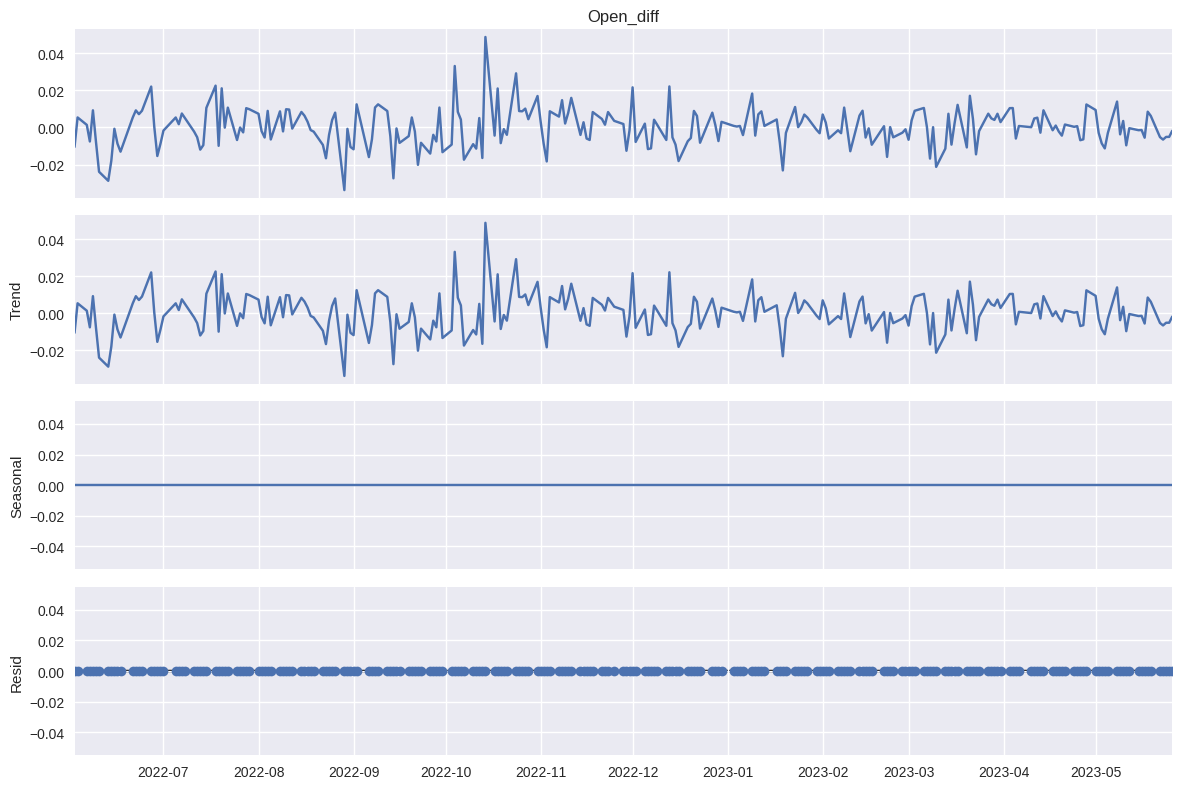

In [261]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(DJI_2_2["Open_diff"], model = "add", period=1)
a.plot();

### División de entrenamiento y prueba

In [262]:
train_data_DJI_2 = DJI_2[:len(DJI_2)-65]
train_data_DJI_2=train_data_DJI_2.drop(train_data_DJI_2.columns[0], axis=1)
test_data_DJI_2 = DJI_2_2[len(DJI_2)-65:]
test_data_DJI_2=test_data_DJI_2.drop(test_data_DJI_2.columns[0], axis=1)
test_DJI_2=test_data_DJI_2.copy()

In [263]:
train_data_DJI_2.shape, test_data_DJI_2.shape

((184, 1), (64, 1))

#### Modelo Auto-Arima
Ejecutemos la función auto_arima() para obtener los mejores parametros de p,d,q,P,D,Q

In [264]:
modelo_auto_DJI=auto_arima(train_data_DJI_2,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto_DJI)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-915.094, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-958.743, Time=0.79 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-913.194, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-980.004, Time=1.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-1005.006, Time=3.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=8.58 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=5.36 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-993.525, Time=1.81 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=-1004.385, Time=8.61 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=5.27 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-1004.160, Time=5.05 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=6.58 sec
 ARIMA(1,1,0)(2,1,1)[12] intercept   : AIC=-10

In [265]:
print(modelo_auto_DJI.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  184
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 507.503
Date:                              Fri, 18 Aug 2023   AIC                          -1005.006
Time:                                      19:44:07   BIC                           -989.298
Sample:                                           0   HQIC                          -998.633
                                              - 184                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0572      0.102      0.559      0.576      -0.143       0.258
ar.S.L12      -0.13

### Implementación del Modelo

In [266]:
arima_model_DJI = SARIMAX(train_data_DJI_2["Open"], order = (0,1,1), seasonal_order = (2,1,2,12))
arima_result_DJI = arima_model_DJI.fit()
arima_result_DJI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Open   No. Observations:                  184
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 507.422
Date:                                 Fri, 18 Aug 2023   AIC                          -1002.844
Time:                                         19:45:26   BIC                           -983.994
Sample:                                              0   HQIC                          -995.196
                                                 - 184                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0640      0.100      0.641      0.522      -0.132       0.260
ar.S.L12      -0.7939      1.151     -0.690      0.490      -3.049       1.461
ar.S.L24      -0.0935      0.112     -0.838      0.402      -0.312       0.125
ma.S.L12      -0.2360      1.099     -0.215      0.830      -2.391       1.919
ma.S.L24      -0.6649      1.153     -0.577      0.564      -2.924       1.594
sigma2         0.0001   2.82e-05      4.733      0.000    7.82e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.38
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

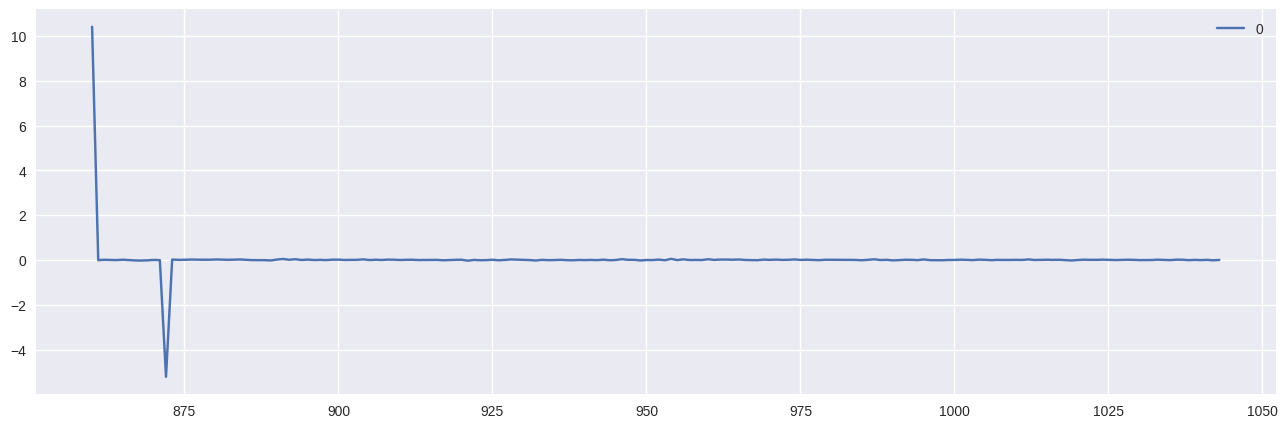

In [267]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result_DJI.resid)
residuals.plot(figsize = (16,5));
plt.show();

#### Cómo interpretar las gráficas de residuos en el modelo ARIMA
Repasemos las gráficas de residuos usando stepwise_fit.

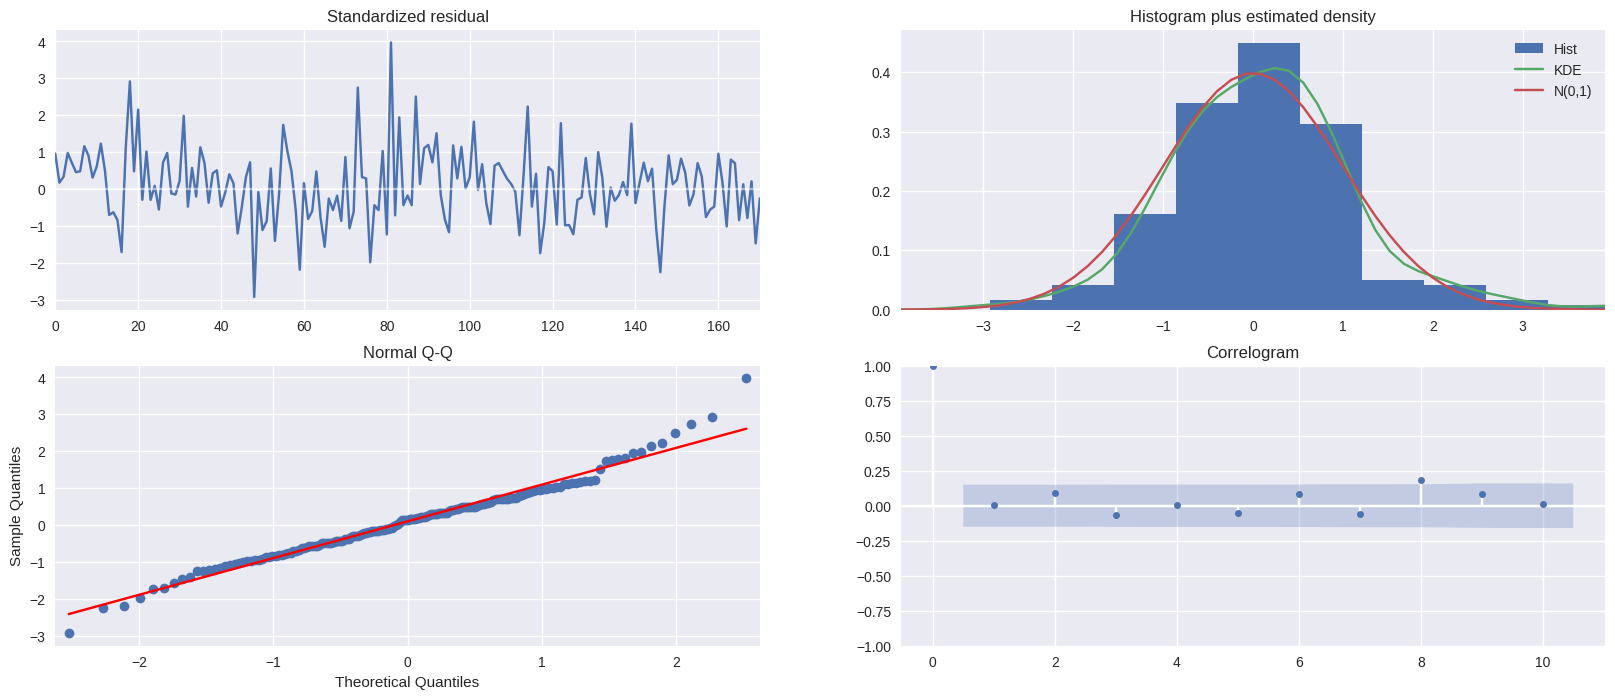

In [268]:
plt.style.use('seaborn')
modelo_auto_DJI.plot_diagnostics(figsize=(20,8))
plt.show()

### Gráfico de resultados

In [272]:
arima_pred_DJI = arima_result_DJI.predict(start = len(train_data_DJI_2), end = len(DJI_2)-1, typ="levels").rename("ARIMA Predictions")

std_pred_DJI=np.std(arima_pred_DJI)
sig_3_mas_DJI=arima_pred_DJI+3*std_pred_DJI
sig_3_men_DJI=arima_pred_DJI-3*std_pred_DJI
sig_2_mas_DJI=arima_pred_DJI+2*std_pred_DJI
sig_2_men_DJI=arima_pred_DJI-2*std_pred_DJI

Tiempo = DJI_2[len(DJI_2)-65:]
tiempo_DJI=Tiempo['Date']
datos_DJI=Tiempo['Open']

upper_trace_DJI = go.Scatter(x=tiempo_DJI,
                    y=sig_3_mas_DJI,
                    mode='lines',
                    fill=None,
                    name='Lím. Sup. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

upper_trace_2_DJI = go.Scatter(x=tiempo_DJI,
                    y=sig_2_mas_DJI,
                    mode='lines',
                    fill=None,
                    name='Lím. Superior 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

lower_trace_DJI = go.Scatter(x=tiempo_DJI,
                    y=sig_3_men_DJI,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

lower_trace_2_DJI = go.Scatter(x=tiempo_DJI,
                    y=sig_2_men_DJI,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

real_trace_DJI = go.Scatter(x=tiempo_DJI,
                    y=datos_DJI,
                    mode='lines',
                    fill=None,
                    name='Valores reales'
                    )

mean_trace_DJI=go.Scatter(x=tiempo_DJI,
                    y=arima_pred_DJI,
                    mode='lines',
                    fill=None,
                    name='Valores modelados'
                    )

data_DJI_3 = [upper_trace_2_DJI, lower_trace_2_DJI, upper_trace_DJI, lower_trace_DJI, real_trace_DJI, mean_trace_DJI]

fig_DJI_est = go.Figure(data=data_DJI_3)
fig_DJI_est.update_layout(title='Cuantificación de incertidumbre EEUU Dow Jones',
            xaxis_title='Tiempo',
            yaxis_title='log_Open (USD)')

fig_DJI_est.update_layout(height=600, width=1000, paper_bgcolor='rgba(255,255,255,0.75)',
    plot_bgcolor='rgba(0,191,255,0.1)', font_color="blue")

fig_DJI_est.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.01), legend_font_size=10)

fig_DJI_est.show()

### Evaluación de la Incertidumbre

# Using 99% confidence bounds
conteo_1_DJI=0
conteo_2_DJI=0
for i in range(len(datos_DJI)):
  if((datos_DJI.iloc[i]>=sig_3_men_DJI.iloc[i]) & (datos_DJI.iloc[i]<=sig_3_mas_DJI.iloc[i])):
    conteo_1_DJI=conteo_1_DJI+1

for i in range(len(datos_DJI)):
  if((datos_DJI.iloc[i]>=sig_2_men_DJI.iloc[i]) & (datos_DJI.iloc[i]<=sig_2_mas_DJI.iloc[i])):
    conteo_2_DJI=conteo_2_DJI+1

rango_1_DJI=conteo_1_DJI/65
rango_2_DJI=conteo_2_DJI/65

print("Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%):", rango_1_DJI)
print("Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%):", rango_2_DJI)

Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%): 0.3076923076923077
Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%): 0.2153846153846154


### Evaluación de los resultados

In [271]:
evaluacion_metrica(datos_DJI, arima_pred_DJI)

Evaluation metric results:-
MSE is : 0.00037399755418174194
MAE is : 0.01503054926264142
RMSE is : 0.01933901637058467
MAPE is : 0.14456395049440945
R2 is : -0.030980450841937568



## EEUU S&P 500

In [273]:
## Infromación del conjunto de datos
GSPC_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 860 to 1108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    249 non-null    datetime64[ns]
 1   Open    249 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [274]:
## Establecer la columna Date como index
GSPC_2_1 = GSPC_2.set_index("Date")

In [275]:
GSPC_2_2=GSPC_2_1.copy()
# Tomar la priemra diferencia
GSPC_2_2['Open_diff'] = GSPC_2_1['Open'].diff()

# Remover el primer datos de la lista
GSPC_2_2.dropna(inplace=True)

# Encabezado de la base de datos
GSPC_2_2.head()

,Open,Open_diff
Date,,
2022-06-02,8.317622,-0.013188
2022-06-03,8.327864,0.010242
2022-06-06,8.327175,-0.000689
2022-06-07,8.317881,-0.009294
2022-06-08,8.330169,0.012288


In [276]:
## Prueba de Dickey_Fuller
Prueba_Dickey_Fuller(GSPC_2_2["Open_diff"],"Open_diff")

Resultados de la prueba de Dickey-Fuller para columna: Open_diff
Test Statistic                       -1.487924e+01
p-value                               1.618841e-27
No Lags Used                          0.000000e+00
Número de observaciones utilizadas    2.470000e+02
Critical Value (1%)                  -3.457105e+00
Critical Value (5%)                  -2.873314e+00
Critical Value (10%)                 -2.573044e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


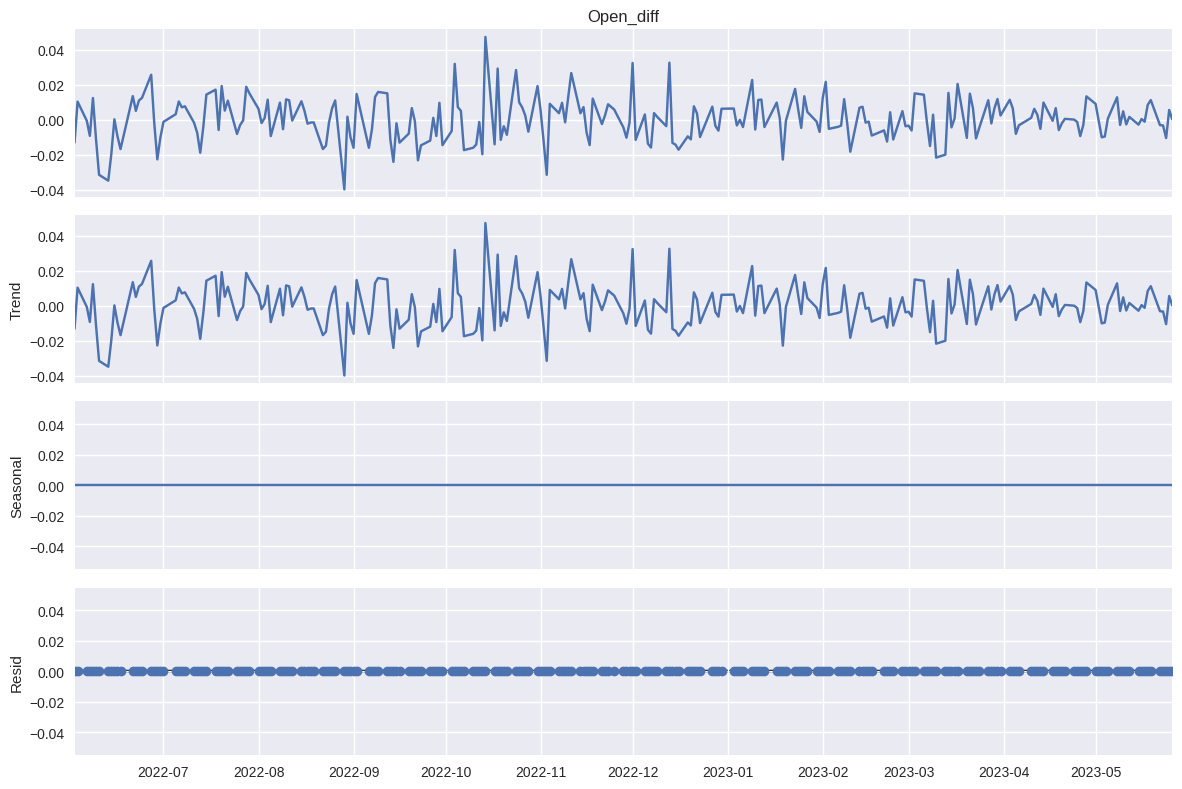

In [277]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(GSPC_2_2["Open_diff"], model = "add", period=1)
a.plot();

### División de entrenamiento y prueba

In [278]:
train_data_GSPC_2 = GSPC_2[:len(GSPC_2)-65]
train_data_GSPC_2=train_data_GSPC_2.drop(train_data_GSPC_2.columns[0], axis=1)
test_data_GSPC_2 = GSPC_2_2[len(GSPC_2)-65:]
test_data_GSPC_2=test_data_GSPC_2.drop(test_data_GSPC_2.columns[0], axis=1)
test_GSPC_2=test_data_GSPC_2.copy()

In [279]:
train_data_GSPC_2.shape, test_data_GSPC_2.shape

((184, 1), (64, 1))

#### Modelo Auto-Arima
Ejecutemos la función auto_arima() para obtener los mejores parametros de p,d,q,P,D,Q

In [280]:
modelo_auto_GSPC=auto_arima(train_data_GSPC_2,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto_GSPC)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-856.940, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-895.592, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-854.989, Time=0.45 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-918.991, Time=4.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=15.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-920.416, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-897.020, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.65 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-918.916, Time=1.26 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-916.950, Time=0.79 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-918.719, Time=2.36 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]      

In [281]:
print(modelo_auto_GSPC.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 463.208
Date:                            Fri, 18 Aug 2023   AIC                           -920.416
Time:                                    19:59:53   BIC                           -910.991
Sample:                                         0   HQIC                          -916.592
                                            - 184                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6775      0.071     -9.483      0.000      -0.818      -0.537
ar.S.L24      -0.3798      0.068   

### Implementación del Modelo

In [282]:
arima_model_GSPC = SARIMAX(train_data_GSPC_2["Open"], order = (0,1,1), seasonal_order = (2,1,2,12))
arima_result_GSPC = arima_model_GSPC.fit()
arima_result_GSPC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Open   No. Observations:                  184
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 478.578
Date:                                 Fri, 18 Aug 2023   AIC                           -945.157
Time:                                         20:00:56   BIC                           -926.307
Sample:                                              0   HQIC                          -937.508
                                                 - 184                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0563      0.084      0.670      0.503      -0.108       0.221
ar.S.L12      -0.7113      0.645     -1.103      0.270      -1.976       0.553
ar.S.L24      -0.1303      0.092     -1.417      0.156      -0.311       0.050
ma.S.L12      -0.3059      0.650     -0.470      0.638      -1.580       0.969
ma.S.L24      -0.5703      0.645     -0.884      0.377      -1.835       0.694
sigma2         0.0002   3.04e-05      6.157      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.98   Prob(JB):                         0.13
Heteroskedasticity (H):               0.87   Skew:                             0.30
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

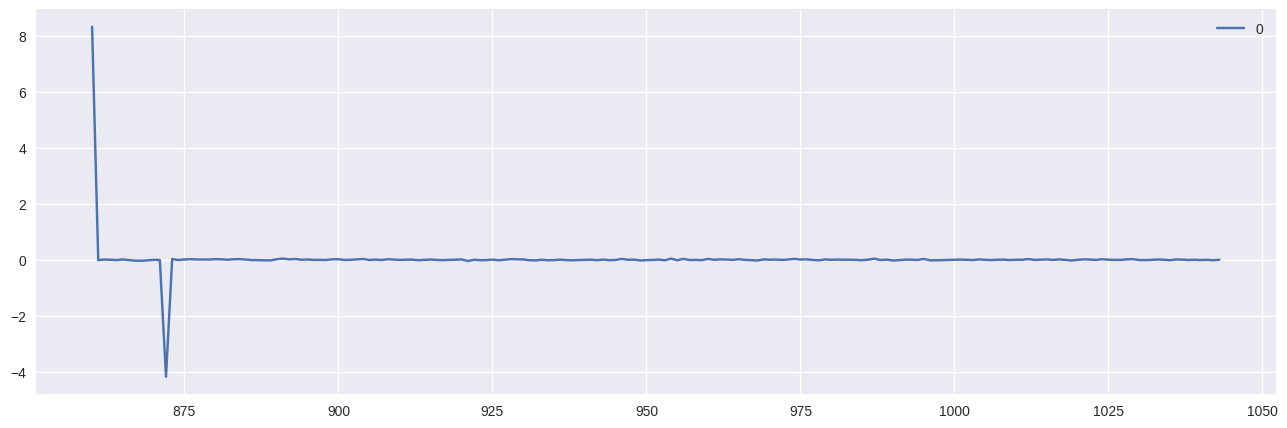

In [283]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result_GSPC.resid)
residuals.plot(figsize = (16,5));
plt.show();

#### Cómo interpretar las gráficas de residuos en el modelo ARIMA
Repasemos las gráficas de residuos usando stepwise_fit.

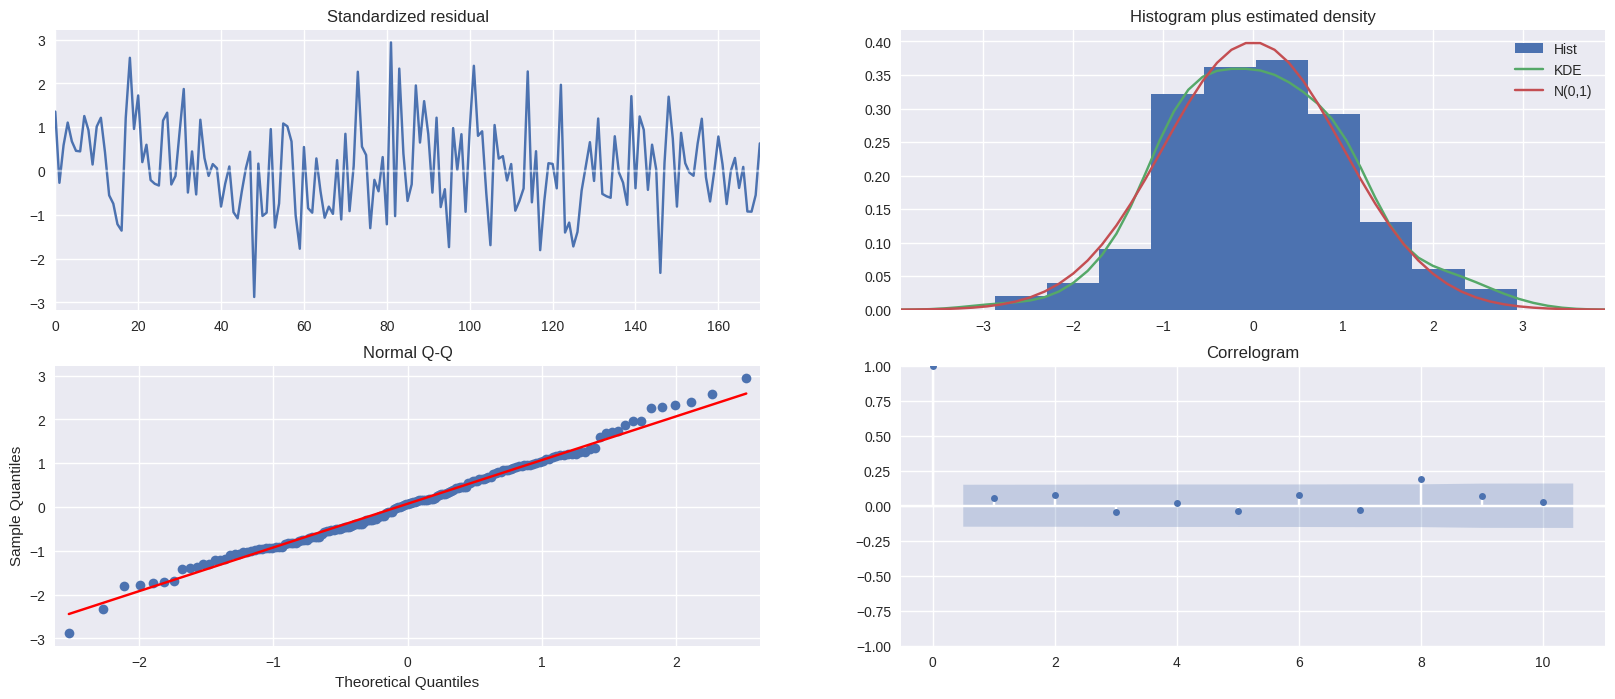

In [284]:
plt.style.use('seaborn')
modelo_auto_GSPC.plot_diagnostics(figsize=(20,8))
plt.show()

### Gráfico de resultados

In [285]:
arima_pred_GSPC = arima_result_GSPC.predict(start = len(train_data_GSPC_2), end = len(GSPC_2)-1, typ="levels").rename("ARIMA Predictions")

std_pred_GSPC=np.std(arima_pred_GSPC)
sig_3_mas_GSPC=arima_pred_GSPC+3*std_pred_GSPC
sig_3_men_GSPC=arima_pred_GSPC-3*std_pred_GSPC
sig_2_mas_GSPC=arima_pred_GSPC+2*std_pred_GSPC
sig_2_men_GSPC=arima_pred_GSPC-2*std_pred_GSPC

Tiempo = GSPC_2[len(GSPC_2)-65:]
tiempo_GSPC=Tiempo['Date']
datos_GSPC=Tiempo['Open']

upper_trace_GSPC = go.Scatter(x=tiempo_GSPC,
                    y=sig_3_mas_GSPC,
                    mode='lines',
                    fill=None,
                    name='Lím. Sup. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

upper_trace_2_GSPC = go.Scatter(x=tiempo_GSPC,
                    y=sig_2_mas_GSPC,
                    mode='lines',
                    fill=None,
                    name='Lím. Superior 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
        )

lower_trace_GSPC = go.Scatter(x=tiempo_GSPC,
                    y=sig_3_men_GSPC,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 3 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

lower_trace_2_GSPC = go.Scatter(x=tiempo_GSPC,
                    y=sig_2_men_GSPC,
                    mode='lines',
                    fill='tonexty',
                    fillcolor='rgba(255, 211, 0, 0.1)',
                    name='Lím. Inf. 2 Sigma',
                    line=dict(color='rgba(255,0,255,0.5)', width=0.5)
                    )

real_trace_GSPC = go.Scatter(x=tiempo_GSPC,
                    y=datos_GSPC,
                    mode='lines',
                    fill=None,
                    name='Valores reales'
                    )

mean_trace_GSPC=go.Scatter(x=tiempo_GSPC,
                    y=arima_pred_GSPC,
                    mode='lines',
                    fill=None,
                    name='Valores modelados'
                    )

data_GSPC_3 = [upper_trace_2_GSPC, lower_trace_2_GSPC, upper_trace_GSPC, lower_trace_GSPC, real_trace_GSPC, mean_trace_GSPC]

fig_GSPC_est = go.Figure(data=data_GSPC_3)
fig_GSPC_est.update_layout(title='Cuantificación de incertidumbre EEUU S&P 500',
            xaxis_title='Tiempo',
            yaxis_title='log_Open (USD)')

fig_GSPC_est.update_layout(height=600, width=1000, paper_bgcolor='rgba(255,255,255,0.75)',
    plot_bgcolor='rgba(0,191,255,0.1)', font_color="blue")

fig_GSPC_est.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.01), legend_font_size=10)

fig_GSPC_est.show()

### Evaluación de la Incertidumbre

# Using 99% confidence bounds
conteo_1_GSPC=0
conteo_2_GSPC=0
for i in range(len(datos_GSPC)):
  if((datos_GSPC.iloc[i]>=sig_3_men_GSPC.iloc[i]) & (datos_GSPC.iloc[i]<=sig_3_mas_GSPC.iloc[i])):
    conteo_1_GSPC=conteo_1_GSPC+1

for i in range(len(datos_GSPC)):
  if((datos_GSPC.iloc[i]>=sig_2_men_GSPC.iloc[i]) & (datos_GSPC.iloc[i]<=sig_2_mas_GSPC.iloc[i])):
    conteo_2_GSPC=conteo_2_GSPC+1

rango_1_GSPC=conteo_1_GSPC/65
rango_2_GSPC=conteo_2_GSPC/65

print("Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%):", rango_1_GSPC)
print("Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%):", rango_2_GSPC)

Proporción de puntos contenidos con un intervalo de confianza 3 sigma (99.97%): 0.09230769230769231
Proporción de puntos contenidos con un intervalo de confianza 2 sigma (95.44%): 0.07692307692307693


### Evaluación de los resultados

In [286]:
evaluacion_metrica(datos_GSPC, arima_pred_GSPC)

Evaluation metric results:-
MSE is : 0.0006049464034403998
MAE is : 0.0218436592331275
RMSE is : 0.024595658223361287
MAPE is : 0.2627549965003078
R2 is : -0.20913094787927355

